In [1]:
import scanpy as sc
import mudata as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from latentcor import gen_data, get_tps, latentcor

import scrublet as scr
import scipy.io
import time
import pickle

In [2]:
path_nSBM = '../data/mudata_nSBM_hierarchy_2.h5mu'
path_KEGG = '../data/mudata_KEGG_hierarchy_2.h5mu'
path_phrog = '../data/mudata_phrog_hierarchy_2.h5mu'

In [3]:
data_nSBM = md.read_h5mu(path_nSBM)
data_nSBM

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 437964 × 32110
  3 modalities
    SC_genes:	437964 x 13536
      obs:	'strains'
      var:	'strains', 'matchin_protein', 'protein'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
    SC_proteins:	437964 x 13090
      obs:	'strains'
      var:	'genes_mapping', 'strains'
      uns:	'Consensus_tree', 'protein_adjacency_matrix', 'protein_match', 'protein_unmatch'
      varm:	'protein_hierarchy'
    SC_PCs:	437964 x 5484
      obs:	'strains'
      var:	'PCs_match'
      uns:	'Consensus_tree_PCs', 'PCs', 'PCs_to_genes', 'PCs_unmatch', 'Purity_info', 'Purity_info_unique', 'protein_match'
      varm:	'protein_hierarchy_PCs'

In [4]:
data_gex = data_nSBM['SC_genes'].copy()
data_gex

AnnData object with n_obs × n_vars = 437964 × 13536
    obs: 'strains'
    var: 'strains', 'matchin_protein', 'protein'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

In [5]:
sc.pp.calculate_qc_metrics(data_gex, var_type="genes", percent_top=None, log1p=False, inplace=True)

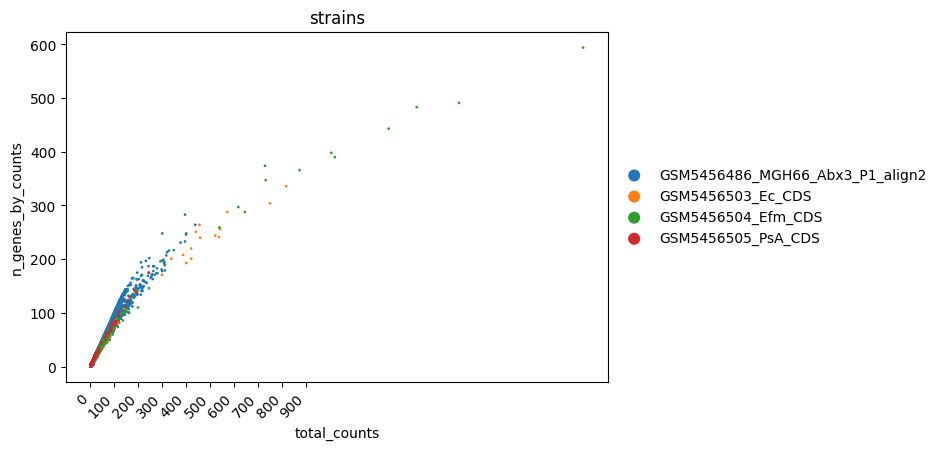

In [6]:
g = sc.pl.scatter(data_gex, x='total_counts', y='n_genes_by_counts', color="strains", show=False, size=15)
g.set_xticks(ticks=range(0, 1000, 100))
g.set_xticklabels(labels=range(0, 1000, 100), rotation=45, ha="right")
plt.show()

In [7]:
print('original data shape:\t\t\t\t', data_gex.shape)
sc.pp.filter_cells(data_gex, min_genes=5)
print('remove cells that have less than 5 genes:\t', data_gex.shape)
sc.pp.filter_cells(data_gex, max_counts=250)
print('remove cells that have more than 250 genes:\t', data_gex.shape)

original data shape:				 (437964, 13536)
remove cells that have less than 5 genes:	 (293905, 13536)
remove cells that have more than 250 genes:	 (293845, 13536)


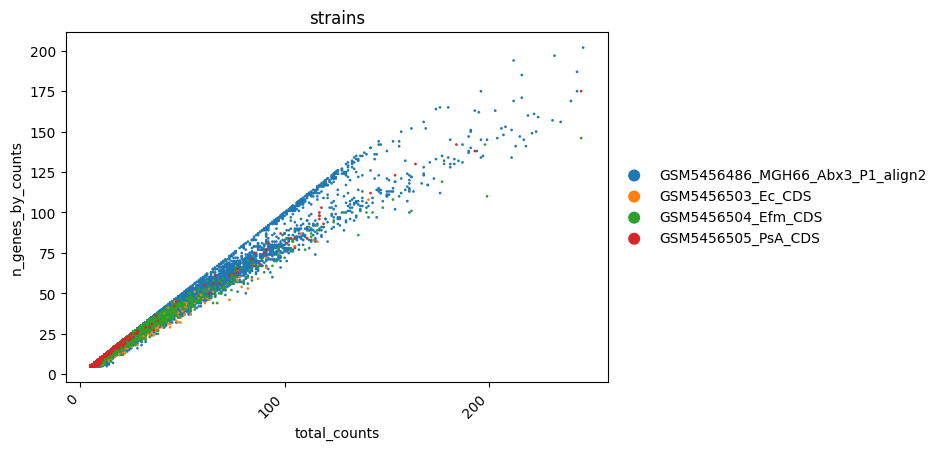

In [8]:
g = sc.pl.scatter(data_gex, x='total_counts', y='n_genes_by_counts', color="strains", show=False, size=15)
g.set_xticks(ticks=range(0, 300, 100))
g.set_xticklabels(labels=range(0, 300, 100), rotation=45, ha="right")
plt.show()

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


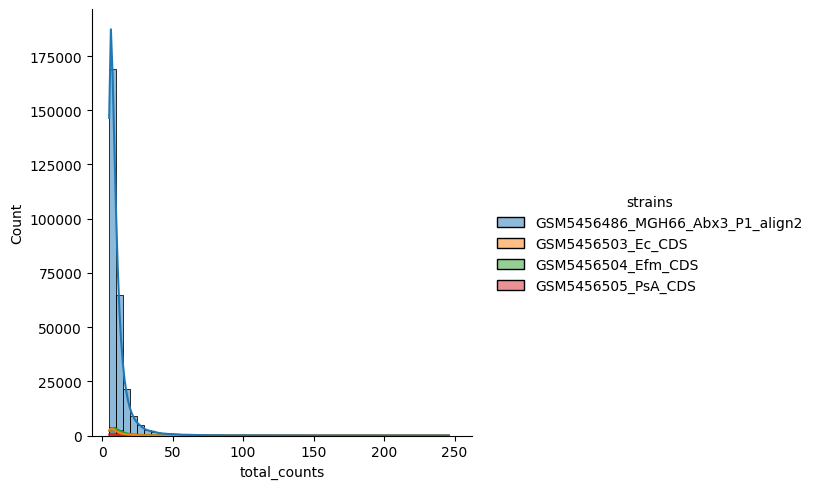

In [9]:
sns.displot(data_gex.obs, x="total_counts", binwidth=5, kde=True, hue="strains")
plt.show()

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


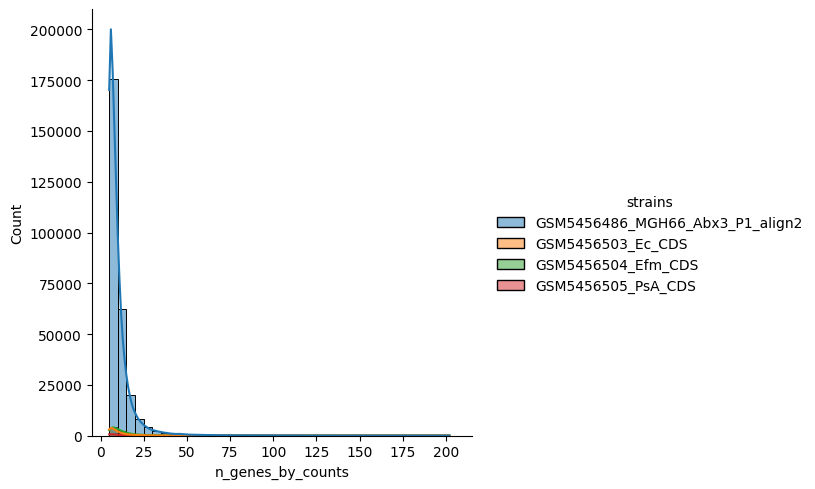

In [10]:
sns.displot(data_gex.obs, x="n_genes_by_counts", binwidth=5, kde=True, hue="strains")
plt.show()

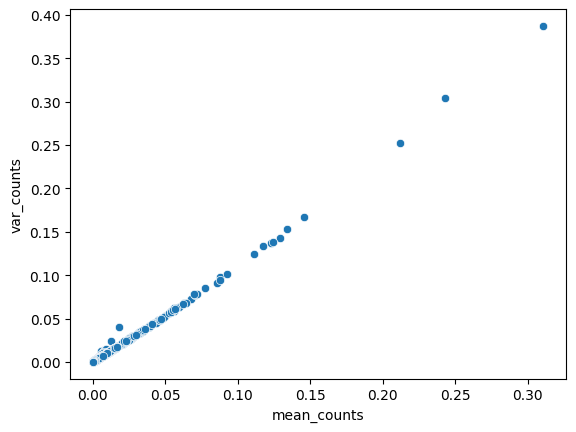

In [11]:
data_gex.var["var_counts"] = np.asarray(np.var(data_gex.X.todense(), axis=0)).squeeze()
data_gex.var["mean_counts"] = np.asarray(np.mean(data_gex.X.todense(), axis=0)).squeeze()
sns.scatterplot(data=data_gex.var, x="mean_counts", y="var_counts")
plt.show()

Add multiple layers to the data that may be helpful later on:

- VST: sqrt
- Normalization: total_sum with target_sum=None


In [12]:
data_gex.layers["counts"] = data_gex.X
data_gex.layers["sqrt_counts"] = np.sqrt(data_gex.X)
data_gex.layers["norm_counts"] = sc.pp.normalize_total(data_gex, target_sum=None, inplace=False)['X'].copy()
data_gex.layers["sqrt_norm_counts"] = np.sqrt(data_gex.layers["norm_counts"])
data_gex

AnnData object with n_obs × n_vars = 293845 × 13536
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts'
    uns: 'genes_match', 'protein_match', 'unmatch_genes', 'strains_colors'
    layers: 'counts', 'sqrt_counts', 'norm_counts', 'sqrt_norm_counts'

Split strain specific into four datasets and remove unused genes

In [15]:
print('original data shape:\t\t', data_gex.shape)
print('--------------------------------------------------')

data_gex_mgh = data_gex[data_gex.obs['strains'] == 'GSM5456486_MGH66_Abx3_P1_align2'].copy()
print('original mgh data shape:\t', data_gex_mgh.shape)
sc.pp.filter_genes(data_gex_mgh, min_cells=1)
print('remove genes that dont appear:\t', data_gex_mgh.shape)
print('--------------------------------------------------')


data_gex_efm = data_gex[data_gex.obs['strains'] == 'GSM5456504_Efm_CDS'].copy()
print('original efm data shape:\t', data_gex_efm.shape)
sc.pp.filter_genes(data_gex_efm, min_cells=1)
print('remove genes that dont appear:\t', data_gex_efm.shape)
print('--------------------------------------------------')


data_gex_ec = data_gex[data_gex.obs['strains'] == 'GSM5456503_Ec_CDS'].copy()
print('original ec data shape:\t\t', data_gex_ec.shape)
sc.pp.filter_genes(data_gex_ec, min_cells=1)
print('remove genes that dont appear:\t', data_gex_ec.shape)
print('--------------------------------------------------')


data_gex_psa = data_gex[data_gex.obs['strains'] == 'GSM5456505_PsA_CDS'].copy()
print('original psa data shape:\t', data_gex_psa.shape)
sc.pp.filter_genes(data_gex_psa, min_cells=1)
print('remove genes that dont appear:\t', data_gex_psa.shape)


original data shape:		 (293845, 13536)
--------------------------------------------------
original mgh data shape:	 (277962, 13536)
remove genes that dont appear:	 (277962, 4031)
--------------------------------------------------
original efm data shape:	 (8613, 13536)
remove genes that dont appear:	 (8613, 2326)
--------------------------------------------------
original ec data shape:		 (5964, 13536)
remove genes that dont appear:	 (5964, 3379)
--------------------------------------------------
original psa data shape:	 (1306, 13536)
remove genes that dont appear:	 (1306, 2657)


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of o

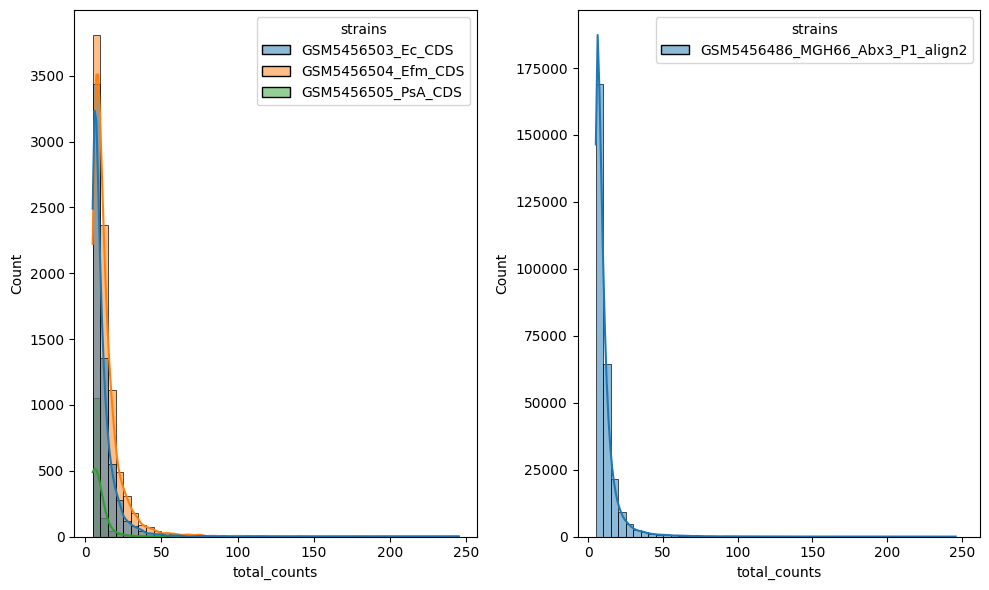

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
sns.histplot(data_gex[data_gex.obs["strains"] != "GSM5456486_MGH66_Abx3_P1_align2"].obs, x="total_counts", binwidth=5, kde=True, hue="strains", ax=axes[0])
sns.histplot(data_gex[data_gex.obs["strains"] == "GSM5456486_MGH66_Abx3_P1_align2"].obs, x="total_counts", binwidth=5, kde=True, hue="strains", ax=axes[1])
plt.tight_layout()
plt.show()

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of o

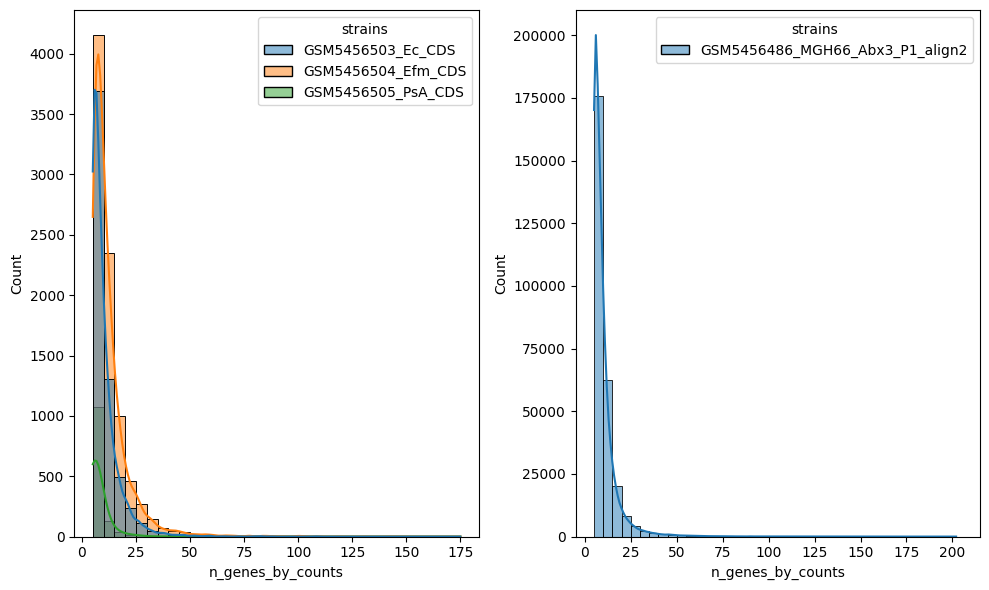

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
sns.histplot(data_gex[data_gex.obs["strains"] != "GSM5456486_MGH66_Abx3_P1_align2"].obs, x="n_genes_by_counts", binwidth=5, kde=True, hue="strains", ax=axes[0])
sns.histplot(data_gex[data_gex.obs["strains"] == "GSM5456486_MGH66_Abx3_P1_align2"].obs, x="n_genes_by_counts", binwidth=5, kde=True, hue="strains", ax=axes[1])
plt.tight_layout()
plt.show()

In [24]:
data_gex_mgh

AnnData object with n_obs × n_vars = 277962 × 4031
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'sqrt_counts', 'norm_counts', 'sqrt_norm_counts'

In [25]:
data_gex_efm

AnnData object with n_obs × n_vars = 8613 × 2326
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'sqrt_counts', 'norm_counts', 'sqrt_norm_counts'

In [26]:
data_gex_ec

AnnData object with n_obs × n_vars = 5964 × 3379
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'sqrt_counts', 'norm_counts', 'sqrt_norm_counts'

In [27]:
data_gex_psa

AnnData object with n_obs × n_vars = 1306 × 2657
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'sqrt_counts', 'norm_counts', 'sqrt_norm_counts'

In [28]:
sc.write(filename='../data/preprocessed/mgh_prepro.h5ad', adata=data_gex_mgh)
sc.write(filename='../data/preprocessed/efm_prepro.h5ad', adata=data_gex_efm)
sc.write(filename='../data/preprocessed/ec_prepro.h5ad', adata=data_gex_ec)
sc.write(filename='../data/preprocessed/psa_prepro.h5ad', adata=data_gex_psa)